In [76]:
from accretion_functions import *
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz, solve_ivp
from scipy.integrate import quad
import os

number_of_points = int(4e2) #How many rows do you want in your DataFrame
#Angular range in theta (theta=0 corresponds to the north pole and theta=pi/2 to the equator)
#For 1pi/6 < theta < 5pi/6 we treat a tours belt over a +/- 60º around the equator.
theta_initial = 1 * np.pi/6 
theta_final = 5 * np.pi/6 
avg_norm_factor, _ = quad(lambda theta: np.sin(theta), theta_initial, theta_final)


G = 6.67430e-8  # Gravitational constant in cgs units
M_sun = 1.989e33  # Solar mass in g
M = 14 * M_sun #Star's mass
R_star = 5.18e10 #Star's radius
K = 4.44540243e+14 # # Polytropic constant K (K = N_n_value * G * R * M**(1/3) in cgs units
gamma = 5/3 # Adiabatic index
c = 2.99792458e10 #Speed of light in cgs
R_Sch = (2 * G * 5.7 * M_sun) / c**2 #Schwarschild radius for a 5.7 M_sun Black Hole


In [77]:
# ----------------------------------------------------
# 1) LOAD DATA AND BUILD INTERPOLATION FUNCTIONS
# ----------------------------------------------------

# (A) Omega vs r
# We assume the CSV has two columns: radius, log10(Omega)
# Then we define an interpolation that directly returns Omega (not log(Omega)).
data_Omega = pd.read_csv('./Data/log_Omega_vs_r.csv', header=None, sep=';', decimal=',')
radius_values_Omega = data_Omega[0].values
log_Omega_values = data_Omega[1].values

# Build an interpolation function for log(Omega)
# We'll store log(Omega) in one function and create a separate "Omega_interpolated" for the 10** step
Omega_function_log = interp1d(
    radius_values_Omega,
    log_Omega_values,
    kind='cubic',
    fill_value="extrapolate",
    bounds_error=False
)

def Omega_interpolated(r):
    """Returns Omega(r) in s^-1 by exponentiating the interpolated log(Omega)."""
    return 10**(Omega_function_log(r))

# (B) Density vs r
# We assume the CSV has two columns: radius, log10(rho)
data_rhoR = pd.read_csv('./Data/log_rho_vs_r.csv', header=None, sep=';', decimal=',')
radius_values_rho = data_rhoR[0].values
log_rho_values_r = data_rhoR[1].values

# Build an interpolation function for log(rho)
density_function_log_r = interp1d(
    radius_values_rho,
    log_rho_values_r,
    kind='cubic',
    fill_value="extrapolate",
    bounds_error=False
)

def rho_interpolated(r):
    """Returns rho(r) in g/cm^3 by exponentiating the interpolated log(rho)."""
    return 10**(density_function_log_r(r))

# (C) If you also have density vs M(r), define it here if needed
# data_rhoM = pd.read_csv('./Data/log_rho_vs_M_r.csv', header=None, sep=';', decimal=',')
# M_r_values_data = data_rhoM[0].values * M_sun
# log_rho_values_M = data_rhoM[1].values
# density_function_log_M = interp1d(M_r_values_data, log_rho_values_M, ...)

# ----------------------------------------------------
# 2) DEFINE ANY ADDITIONAL FUNCTIONS
# ----------------------------------------------------

def M_r(r):
    """
    Computes M(r) by integrating 2*pi * avg_norm_factor * r'^2 * rho_interpolated(r').
    The integration is from 1e6 cm up to r.
    Returns mass in grams.
    """
    # We assume r >= 1e6, otherwise we need a check
    result, _ = quad(
        lambda r_prime: 2.0 * np.pi * avg_norm_factor * (r_prime**2) * rho_interpolated(r_prime),
        1e6,  # lower limit of integration
        r     # upper limit
    )
    return result  # in grams

# ----------------------------------------------------
# 3) MAIN COMPUTATION
# ----------------------------------------------------

# Define the range of radii in cm
r_values = np.logspace(7, 10.69, number_of_points)  # example range

# Prepare a list to store the data
data_list = []

for r in r_values:
    # Compute rho(r)
    rho_val = rho_interpolated(r)
    # Compute Omega(r)
    Omega_val = Omega_interpolated(r)
    # Compute M(r)
    M_r_val = M_r(r)

    data_list.append([r, rho_val, M_r_val, Omega_val])

# Convert the list to a DataFrame
df = pd.DataFrame(data_list, columns=['r', 'rho_r', 'M_r', 'Omega_r'])

# Compute additional columns
df['Omega_k'] = np.sqrt(G * df['M_r'] / df['r']**3)  # Keplerian angular velocity
df['tau'] = np.log(df['rho_r']).diff() / np.log(df['r']).diff()

# Save the final data
df.to_csv('data.csv', index=False, float_format='%.8e')

print("Data saved to data.csv")


/tmp/ipykernel_1553136/428178180.py:62: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result, _ = quad(


Data saved to data.csv


# Control plots of $\rho_r$, $\Omega_r$, $M_r$ and $\Omega_k$

$\rho_r$ and $\Omega_r$, were interpolated from Figure 2 in (Kumar, 2008). While 


\begin{equation}
    M_r=\int_0^{2\pi}d\phi\ \int_{\theta_1}^{\theta_2}\sin\theta d\theta\   \int_0^R  r^2\rho (r) dr = 2\pi\  ({\rm  avg\_norm\_factor})  \int_0^R  r^2\rho (r) dr  \ .
\end{equation}

On the other hand the Keplerian angular velocity ($\Omega_k$): The Keplerian angular velocity is defined as 
\begin{equation}
      \Omega_k = \left( \frac{G M_r}{r^3} \right)^{1/2},
\end{equation}

where $G$ is the gravitational constantin cgs units, $M_r$ is the mass enclosed within radius $r$, and $r$ is the radial distance from the central object.



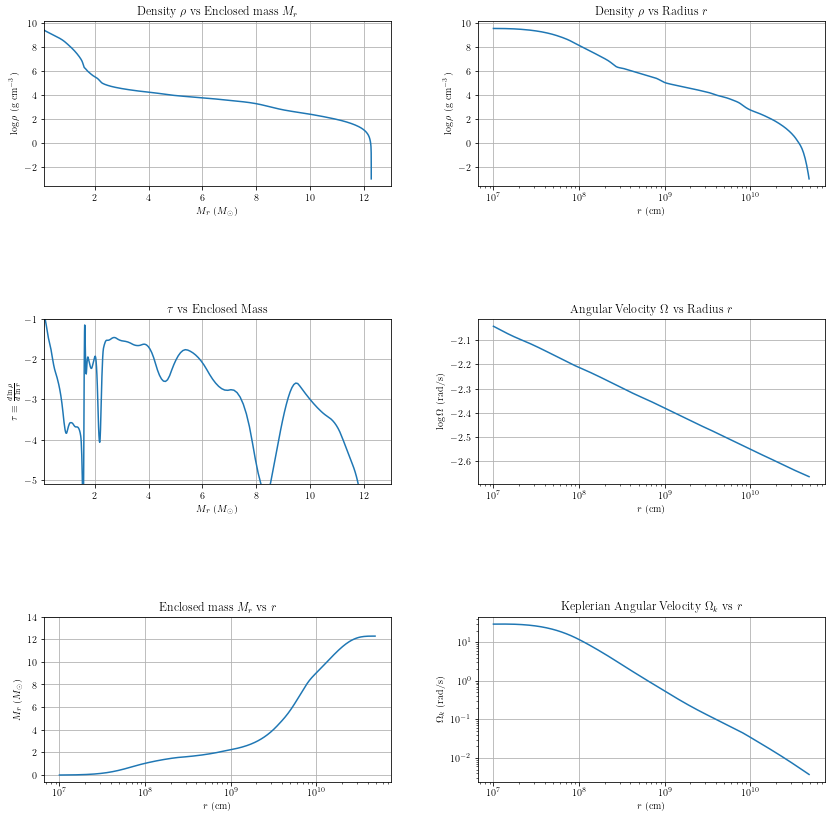

In [78]:
df = pd.read_csv('data.csv')

# Plotting
plt.figure(figsize=(14,14))
plt.subplots_adjust(hspace=0.8)
plt.subplots_adjust(wspace=0.25)


plt.subplot(3, 2, 1)
plt.plot(df['M_r']/M_sun, np.log10(df['rho_r']))
plt.xlabel(r'$M_r$ ($M_\odot$)')
plt.ylabel(r'$\log \rho$ (g cm$^{-3}$)')
plt.grid(True)
plt.xticks(np.arange(0, 13, 2))
plt.xlim(0.1,13)
plt.title(r'Density $\rho$ vs Enclosed mass $M_r$ ')

plt.subplot(3, 2, 2)
plt.semilogx(df['r'], np.log10(df['rho_r']))
plt.xlabel(r'$r$ (cm)')
plt.ylabel(r'$\log \rho$ (g cm$^{-3}$)')
plt.grid(True)
plt.title(r'Density $\rho$ vs Radius $r$')

plt.subplot(3, 2, 3)
plt.plot(df['M_r']/M_sun, df['tau'])
plt.xlabel(r'$M_r$ ($M_\odot$)')
plt.ylabel(r'$\tau\equiv\frac{d\ln\rho}{d\ln r}$')
plt.ylim(-5.1,-1)
plt.xticks(np.arange(0, 13, 2))
plt.xlim(0.1,13)
plt.title(r'$\tau$ vs Enclosed Mass')
plt.grid(True)

plt.subplot(3, 2, 4)
plt.semilogx(df['r'], np.log10(df['Omega_r']))
plt.xlabel(r'$r$ (cm)')
plt.ylabel(r'$\log \Omega$ (rad/s)')
plt.grid(True)
plt.title(r'Angular Velocity $\Omega$ vs Radius $r$')

plt.subplot(3, 2, 5)
plt.semilogx(df['r'], df['M_r']/M_sun)
plt.xlabel(r'$r$ (cm)')
plt.ylabel(r'$M_r$ ($M_\odot$)')
plt.grid(True)
ticks_y_Mr = [0, 2, 4, 6, 8, 10, 12, 14]
plt.yticks(ticks_y_Mr)
plt.title(r'Enclosed mass $M_r$ vs $r$')

plt.subplot(3, 2, 6)
plt.loglog(df['r'], df['Omega_k'])
plt.xlabel(r'$r$ (cm)')
plt.ylabel(r'$\Omega_k$ (rad/s)')
plt.grid(True)
plt.title(r'Keplerian Angular Velocity $\Omega_k$ vs $r$')

plt.show()

# Definition of $t_{\rm eq}$ and $r_{\rm eq}$

In order to define the baove equations, we require first the eccentricity $e(r,\theta)$ function, which is defined as follows:
\begin{equation}
   e(r,\theta)=1-\frac{\Omega_r^2}{\Omega_k^2}\sin^2\theta\ ,
\end{equation}

In this way, the equatorial radius $r_{\rm eq}$ is defined as $r_{\rm eq}(r,\theta)=r(1-e)$ and the equatorial timescale $ t_{\rm eq}(r,\theta)$ is

\begin{equation}
    \label{eq:teq}
    t_{\rm eq}(r,\theta)= \dfrac{1}{\Omega_k}\left(\arccos(-e)+e\sqrt{1-e^2}\right)(1+e)^{-3/2}+t_s(r)  \ ,
\end{equation}

For simplicity, this function is now averaged over theta to eliminate this angular dependence. A wedge integration range of +60º over the equator is considered, assuming that the mass fall-back occurs only within this regime.

    

\begin{align}
    \label{eq:avg_ecc}
   \langle 
{t_{\rm eq}(r,\theta)}_\theta \rangle&=\dfrac{1}{\Delta \Omega} \int_0^{2\pi}\int_{\theta_1}^{\theta_2} t_{\rm eq}(r,\theta)\sin\theta\ d\theta\ d\phi\ , \\ \nonumber
         &= \dfrac{ \int_0^{2\pi}\int_{\theta_1}^{\theta_2} t_{\rm eq}(r,\theta)\sin\theta\ d\theta\ d\phi\ }{\int_0^{2\pi}\int_{\theta_1}^{\theta_2} \sin\theta\ d\theta\ d\phi\ } \ , \\ \nonumber
         &= \dfrac{{2\pi}\int_{\theta_1}^{\theta_2} t_{\rm eq}(r,\theta)\sin\theta\ d\theta\  }{{2\pi}\int_{\theta_1}^{\theta_2} \sin\theta\ d\theta\ \ } \ .
\end{align}

and analogously for $r_{\rm eq}(r,\theta)=r(1-e)$.

In [79]:
df = pd.read_csv('data.csv')
from scipy.integrate import quad

def eccentricity(row, theta):
    return 1 - ((row['Omega_r'] / row['Omega_k']) * np.sin(theta))**2


# Average eccentricity funcion from a range of theta
def avg_teq(row):
    def t_eq_2v(theta):
        e = eccentricity(row, theta)
        parenthesis = (np.arccos(-e) + e * np.sqrt(1 - e**2)) * (1 + e)**(-1.5)
        #t_s_val = R_star / (np.sqrt(gamma * K * row['rho_r']**(2/3)))  
        t_s_val =  1 / row['Omega_k']
        t_eq_val = ( 1 / row['Omega_k']) * parenthesis + t_s_val
        return t_eq_val    
    integrand = lambda theta: t_eq_2v(theta) * np.sin(theta)
    integral, _ = quad(integrand,  theta_initial, theta_final)
    return integral / avg_norm_factor

def avg_req(row):
    def r_fb(theta):
        e = eccentricity(row, theta)
        return row['r'] * (1 - e)
    integrand = lambda theta: r_fb(theta) * np.sin(theta)
    integral, _ = quad(integrand, theta_initial, theta_final)
    avg_req_val = integral / avg_norm_factor
    return avg_req_val

def avg_v_phi(row):
    def v_phi(theta):
        e = eccentricity(row, theta)
        return -(row['r'] * row['Omega_k'] * np.sin(theta)) / np.sqrt(1 - e)
    integral, _ = quad(v_phi, theta_initial, theta_final)
    return integral / avg_norm_factor



#df['c_s'] = np.sqrt(gamma * K * df['rho_r']**(2/3))
#df['t_s_polytropic'] = R_star / df['c_s']
#df['t_s_keplerian'] = 1 / df['Omega_k']

df['v_phi'] = df.apply(avg_v_phi, axis=1)

df['avg_req'] = df.apply(avg_req, axis=1)

df['r_fb'] = df['r'] * (df['Omega_r'] / df['Omega_k'])**2

df['avg_teq'] = df.apply(avg_teq, axis=1)

df.to_csv('data.csv', index=False,float_format='%.8e')


## Control plots of $t_{\rm eq}(r,\theta)$ and $r_{\rm eq}(r,\theta)$

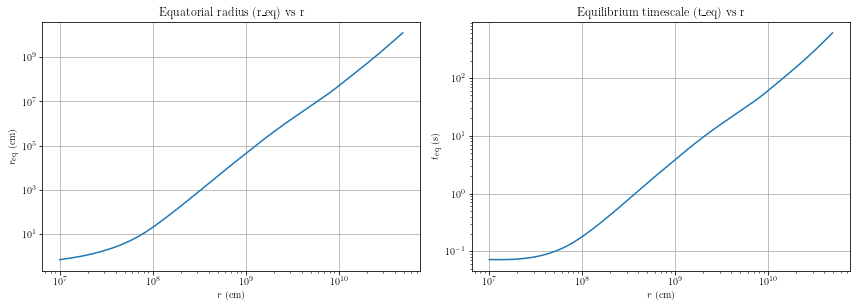

In [80]:
df = pd.read_csv('data.csv')

plt.figure(figsize=(12, 8))
R_Sch = (2 * G * 5.7 * M_sun) / c**2
# Plot r_eq vs r
plt.subplot(2, 2, 1)
plt.loglog(df['r'], df['avg_req'])
plt.xlabel(r'$r$ (cm)')
plt.ylabel(r'$r_{\rm eq}$ (cm)')
plt.grid(True)
plt.title('Equatorial radius (r_eq) vs r')

# Plot t_eq vs r
plt.subplot(2, 2, 2)
plt.loglog(df['r'], df['avg_teq'])
plt.xlabel(r'$r$ (cm)')
plt.ylabel(r'$t_{\rm eq}$ (s)')
plt.grid(True)
plt.title('Equilibrium timescale (t_eq) vs r')

plt.tight_layout()
plt.show()

## Mass fall-back rate

Mass fall-back rate ($\dot{M}_{\rm fb}$) Black Hole mass ($M_{\rm BH}$): $\dot{M}_{\rm fb}$ describes the rate at which mass falls back onto the disk, and $M_{\rm BH}$ is the mass of the central black hole, accumulated over time. Before calculating the mass fall-back radius, an auxiliary function $H_t$ has to be obtained, defined as
    \begin{equation}
        \label{eq:H_t}
        H_t^{-1} \equiv \left|\dfrac{d}{dr}\ln|t_{\rm eq}|\right|\ ,
    \end{equation} such that,

\begin{equation}
    \dot M_{\rm fb}(t)\equiv \dfrac{d M(r)}{ d t_{\rm eq}}  = \dfrac{d M(r)}{ dr} \dfrac{dr}{ d t_{\rm eq}}=2\pi r^2\rho(r)\dfrac{H_t}{t_{\rm eq}}\displaystyle\int_{\theta_{1}}^{\theta_2}\sin\theta\ d\theta\ ,
\end{equation} 
where on the one hand  $\dfrac{dM(r)}{dr}=2\pi r^2\rho(r)\displaystyle\int_{\theta_{1}}^{\theta_2}\sin\theta\ d\theta$ for the northern hermisphere and on the other hand $\dfrac{dr}{ d t_{\rm eq}}=\dfrac{H_t}{t_{\rm eq}}$ where we have used the chain rule and the fact that $\dfrac{dt_{\rm eq}}{dr} = H_t^{-1}\ t_{\rm eq}$. In this equation, $\displaystyle\int_{\theta_{1}}^{\theta_2}\sin\theta\ d\theta\equiv$ avg_norm_factor.\\

Likewise, the mass of the black hole is obtained by integrating the previous Equation 

\begin{equation}
    \label{eq:M_BH}
    M_{\rm BH} = \int_0^{t_{\rm eq}} \dot{M}_{\rm fb} (t_{\rm eq})\ dt_{\rm eq}\ .
\end{equation}

In the same way, for the northern hemisphere $dJ_r = r\times(dm\cdot\Omega)$ with $dm = 2\pi r^2\rho(r)\displaystyle\int_{\theta_{1}}^{\theta_2}\sin\theta\ d\theta$, so
\begin{equation}
J_r=\int_0^{2\pi}\phi\ d\phi  \int_0^R  r^4\rho(r)\Omega_r\ dr \displaystyle\int_{\theta_{1}}^{\theta_2}\sin\theta\ d\theta=2\pi r^4\rho(r)\ \Omega_r*{\text avg\_norm\_factor}
\end{equation}

Once we have the expressions for the angular momentum and the enclosed mass as a function of radius, the additional spin parameter is defined as
\begin{equation}
    \label{eq:a_*}
    a_*=\dfrac{cJ_r}{GM_r^2}\ ,
\end{equation}





In [81]:
df = pd.read_csv('data.csv')
df.sort_values(by='r', inplace=True)


df['H_t'] = 1 / np.abs(np.gradient(np.log(df['avg_teq']), df['r'], edge_order=2))

df['Mfb_dot'] = 2 *  np.pi * df['r']**2 * df['rho_r'] * avg_norm_factor * (df['H_t'] / df['avg_teq'])

df['M_BH'] =  cumtrapz(df['Mfb_dot'], x=df['avg_teq'], initial=0)

df['integrand'] =  2 *  np.pi * df['r']**4 * df['rho_r'] * df['Omega_r'] * avg_norm_factor
df['J_r'] = cumtrapz(df['integrand'], df['r'], initial=0)
df.drop(columns=['integrand'], inplace=True)

df['a_star'] = (c * df['J_r']) / (G * df['M_r']**2)

df.to_csv('data.csv', index=False, float_format='%.8e')

# Definition of $R_{\rm isco}$

The radius of the ISCO  for a black hole of mass $M_{\rm BH}$ , and $a_*$ is given by:

\begin{equation}
    \label{eq:Risco_fb}
R_{\rm isco}(r) = r {\Omega^2(r)\over\Omega_k^2(r)}\ ,
\end{equation}
and
\begin{equation}
    \label{eq:Risco}
    R_{\text{isco}}(M_{\rm BH},a_*) = \frac{GM_{\rm BH}}{c^2} \left\{ 3 + z_2 - \left[(3-z_1)(3+z_1+2z_2)\right]^{1/2} \right\}\ ,
\end{equation}

with

\begin{equation}
    \label{eq:z1_z2}
    z_1 = 1 + \left(1 - a_*^2\right)^{1/3}\left[ (1+a_*)^{1/3} + (1-a_*)^{1/3} \right], \quad\text{and}\quad z_2 = \left(3 a_*^2 + z_1^2\right)^{1/2}\ .
\end{equation}



These equations are solved numerically to calculate the critical radius $r$ and timescale ($t_{\rm eq}$) inside which all the mass falls directly into the black hole, thereby obtaining the initial mass of the black hole $M_{\rm BH}$ , and $a_*$.


In [82]:
df = pd.read_csv('data.csv')
df.sort_values(by='r', inplace=True)

def R_isco(M_BH, a_star):
    z1 = 1 + (1 - a_star**2)**(1/3) * ((1 + a_star)**(1/3) + (1 - a_star)**(1/3))
    z2 = np.sqrt(3 * a_star**2 + z1**2)
    return (G * M_BH / c**2) * (3 + z2 - np.sqrt((3 - z1) * (3 + z1 + 2 * z2)))

df['R_isco'] = df.apply(lambda row: R_isco(row['M_BH'], row['a_star']), axis=1)
df['Jfb_dot'] = df['Mfb_dot'] * df['r_fb'] * df['v_phi'].abs()


df.to_csv('data.csv', index=False, float_format='%.8e')

/tmp/ipykernel_1553136/3105345406.py:5: RuntimeWarning: invalid value encountered in double_scalars
  z1 = 1 + (1 - a_star**2)**(1/3) * ((1 + a_star)**(1/3) + (1 - a_star)**(1/3))


# Control plots of the previously defined functions

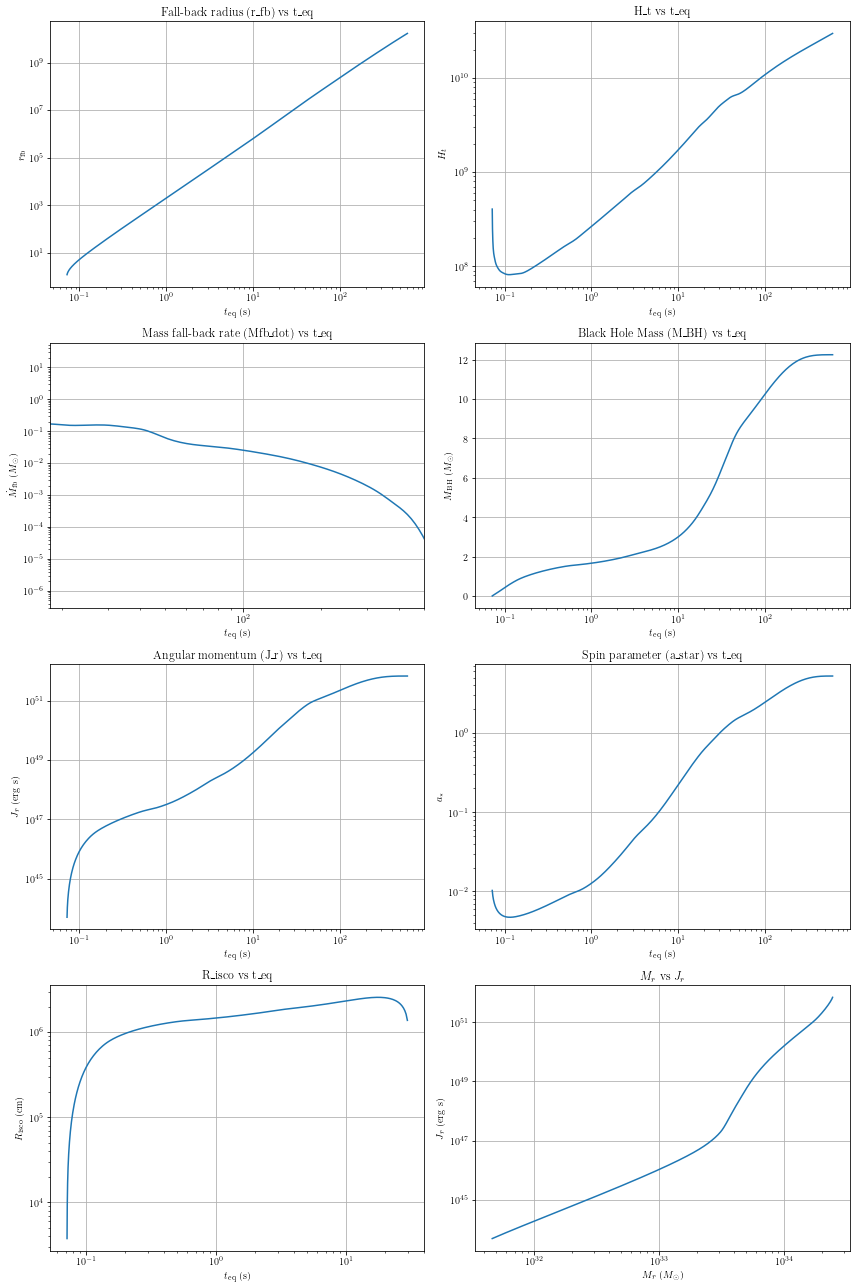

In [83]:
df = pd.read_csv('data.csv')
df = df.iloc[20:].reset_index(drop=True)
# Ensure t_eq is in the correct numeric format
df['avg_teq'] = pd.to_numeric(df['avg_teq'], errors='coerce')

plt.figure(figsize=(12, 18)) 

# Plot r_fb vs t_eq
plt.subplot(4, 2, 1)  # Row 1, Column 1
plt.loglog(df['avg_teq'], df['r_fb'])
plt.xlabel(r'$t_{\rm eq}$ (s)')
plt.ylabel(r'$r_{\rm fb}$')
#plt.xlim(1e1,7e2)
plt.title('Fall-back radius (r_fb) vs t_eq')
plt.grid(True)

# Plot H_t vs t_eq
plt.subplot(4, 2, 2)  # Row 1, Column 2
plt.loglog(df['avg_teq'], df['H_t'])
plt.xlabel(r'$t_{\rm eq}$ (s)')
plt.ylabel(r'$H_t$')
plt.title('H_t vs t_eq')
plt.grid(True)

# Plot Mfb_dot vs t_eq
plt.subplot(4, 2, 3)  # Row 2, Column 1
plt.loglog(df['avg_teq'], df['Mfb_dot']/M_sun)
plt.xlabel(r'$t_{\rm eq}$ (s)')
plt.xlim(18,500)
plt.ylabel(r'$\dot{M}_{\rm fb}$ ($M_\odot$)')
plt.title('Mass fall-back rate (Mfb_dot) vs t_eq')
plt.grid(True)

# Plot M_BH vs t_eq
plt.subplot(4, 2, 4)  # Row 2, Column 2
plt.semilogx(df['avg_teq'], df['M_BH']/M_sun)
plt.xlabel(r'$t_{\rm eq}$ (s)')
plt.ylabel(r'$M_{\rm BH}$ ($M_\odot$)')
plt.title('Black Hole Mass (M_BH) vs t_eq')
plt.grid(True)

# Plot J_r vs t_eq
plt.subplot(4, 2, 5)  # Row 3, Column 1
plt.loglog(df['avg_teq'], df['J_r'])
plt.xlabel(r'$t_{\rm eq}$ (s)')
plt.ylabel(r'$J_r$ (erg s)')
plt.title('Angular momentum (J_r) vs t_eq')
plt.grid(True)

# Plot a_star vs t_eq
plt.subplot(4, 2, 6)  # Row 3, Column 2
plt.loglog(df['avg_teq'], df['a_star'])
plt.xlabel(r'$t_{\rm eq}$ (s)')
plt.ylabel(r'$a_*$')
plt.title('Spin parameter (a_star) vs t_eq')
plt.grid(True)

# Plot R_isco vs t_eq
plt.subplot(4, 2, 7)  # Row 4, Column 1
plt.loglog(df['avg_teq'], df['R_isco'])
plt.xlabel(r'$t_{\rm eq}$ (s)')
plt.ylabel(r'$R_{\rm isco}$ (cm)')
plt.title('R_isco vs t_eq')
plt.grid(True)

# Plot J_r vs M_r
plt.subplot(4, 2, 8)  # Row 4, Column 2
plt.loglog(df['M_r'], df['J_r'])
plt.xlabel(r'$M_r$ ($M_\odot$)')
plt.ylabel(r'$J_r$ (erg s)')
plt.title(r'$M_r$ vs $J_r$')
plt.grid(True)

plt.tight_layout()
plt.show()

# Finding the intersection point between $r_{\rm fb}$ and $R_{\rm isco}$

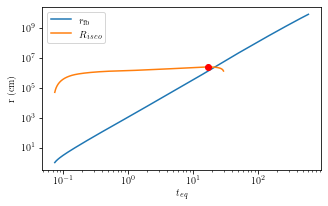

Closest t_eq : 17.24 s
r_crit: 3.35e+09 cm, a_star: 0.51, M_BH: 4.17 M_sun


In [84]:
df = pd.read_csv('data.csv') 
remove_rows = int(number_of_points/10)
# Remove the first (number_of_points/10) rows from the DataFrame to eliminate the initial outlier
df = df.iloc[remove_rows:].reset_index(drop=True)

R_isco_valid_range = df['avg_teq'][df['R_isco'].notna()]
rfb_r_valid_range = df['avg_teq'][df['r_fb'].notna()]

R_isco_interp = interp1d(R_isco_valid_range, df['R_isco'][df['R_isco'].notna()], kind='cubic')
rfb_r_interp = interp1d(rfb_r_valid_range, df['r_fb'][df['r_fb'].notna()], kind='cubic')

mint = max(df['avg_teq'].min(), R_isco_valid_range.min(), rfb_r_valid_range.min())
maxt = min(df['avg_teq'].max(), R_isco_valid_range.max(), rfb_r_valid_range.max())

def intersection_diff(t_eq):
    return abs(rfb_r_interp(t_eq) - R_isco_interp(t_eq))

t_eq_range = np.linspace(mint, maxt, 500)
intersection = min(t_eq_range, key=intersection_diff)

# Plot
plt.figure(figsize=(5, 3))
plt.loglog(df['avg_teq'], df['avg_req']/1.4, label=r"$r_{\rm fb}$")
plt.loglog(R_isco_valid_range, R_isco_interp(R_isco_valid_range), label="$R_{ isco}$")
plt.scatter([intersection], [rfb_r_interp(intersection)], color='red', zorder=5)
plt.xlabel(r'$t_{eq}$')
plt.ylabel('r (cm)')
plt.legend()
plt.show()

closest_index = (df['avg_teq'] - intersection).abs().idxmin()
closest_row = df.iloc[closest_index]
print(f"Closest t_eq : {intersection:.2f} s")
print(f"r_crit: {closest_row['r']:.2e} cm, a_star: {closest_row['a_star']:.2f}, M_BH: {closest_row['M_BH']/M_sun:.2f} M_sun")


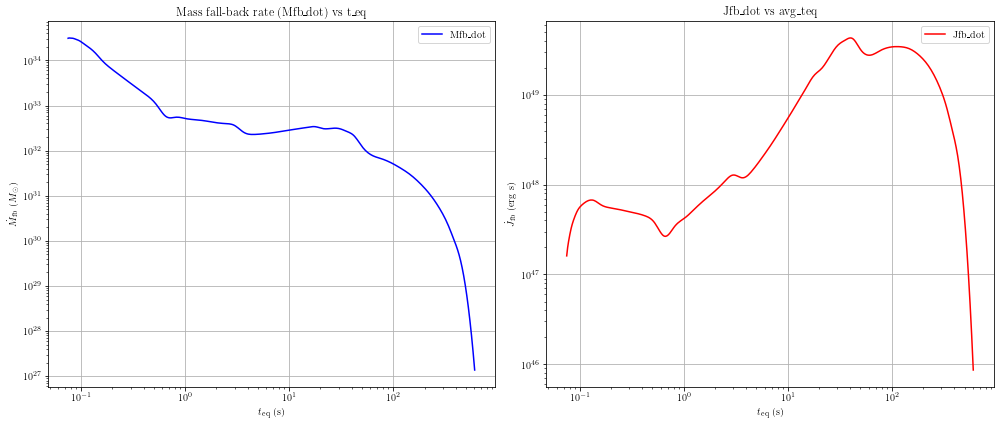

In [85]:

Jfb_dot_interp = interp1d(df['avg_teq'], df['Jfb_dot'], bounds_error=False, fill_value="extrapolate")

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.loglog(df['avg_teq'], df['Mfb_dot'], label='Mfb_dot', color='blue')
plt.xlabel(r'$t_{\rm eq}$ (s)')
plt.ylabel(r'$\dot{M}_{\rm fb}$ ($M_\odot$)')
#plt.xlim(18,500)
plt.title('Mass fall-back rate (Mfb_dot) vs t_eq')
plt.grid(True)

plt.legend()

plt.subplot(1, 2, 2)
plt.loglog(df['avg_teq'], df['Jfb_dot'], label='Jfb_dot', color='red')
plt.xlabel(r'$t_{\rm eq}$ (s)')
plt.ylabel(r'$\dot{J}_{\rm fb}$ (erg s)')
plt.title('Jfb_dot vs avg_teq')
plt.grid(True)
plt.legend()


plt.tight_layout()
plt.show()


In [86]:
# Constants and initial conditions setup
G = 6.67430e-8  # Gravitational constant, cm^3 g^-1 s^-2
c = 2.99792458e10  # Speed of light, cm/s
M_sun = 1.989e33  # Solar mass, g

alpha = 0.1  # Viscosity parameter
s = 0.5  # Model parameter

# Initial conditions
t0 = 17
a_star0 = 0.51
M_BH0 = 4.17 * M_sun  # Initial black hole mass
#a_star0 = 0.45
#M_BH0 = 5.7 * M_sun

J_BH0 = (a_star0 * G * M_BH0**2) / c  # Initial black hole angular momentum calculated from a_star0
M_d0 = 1e-10 * M_BH0   # Initial disk mass
J_d0 = 1e-10 * J_BH0 # Initial disk angular momentum

# Load DataFrame and interpolation functions
df = pd.read_csv('data.csv')
df.sort_values(by='avg_teq', inplace=True)
Mfb_dot_interp = interp1d(df['avg_teq'], df['Mfb_dot'], bounds_error=False, fill_value="extrapolate")
Jfb_dot_interp = interp1d(df['avg_teq'], df['Jfb_dot'], bounds_error=False, fill_value="extrapolate")


# Functions
def a_star_BH(J_BH, M_BH):
    return (c * J_BH) / (G * M_BH**2)

def R_S(M_BH):
    return 2 * G * M_BH / c**2

def R_isco_BH(M_BH, J_BH):
    a_star_val = a_star_BH(J_BH=J_BH, M_BH=M_BH)  # Use the spin parameter from a_star_BH function
    z1 = 1 + (1 - a_star_val**2)**(1/3) * ((1 + a_star_val)**(1/3) + (1 - a_star_val)**(1/3))
    z2 = np.sqrt(3 * a_star_val**2 + z1**2)
    return (G * M_BH / c**2) * (3 + z2 - np.sqrt((3 - z1) * (3 + z1 + 2 * z2)))

def j_isco(M_BH, J_BH):
    a_star_val = a_star_BH(M_BH=M_BH, J_BH=J_BH)
    R_isco_val = R_isco_BH(M_BH=M_BH, J_BH=J_BH)
    R_s_val = R_S(M_BH=M_BH)
    numerator = (R_isco_val**2 - a_star_val * R_s_val * np.sqrt(R_isco_val * R_s_val / 2) + a_star_val**2 * R_s_val**2 / 4)
    denominator = R_isco_val * np.sqrt(R_isco_val**2 - 3 * R_isco_val * R_s_val / 2 + a_star_val * R_s_val * np.sqrt(R_isco_val * R_s_val / 2))
     
    return np.sqrt(G * M_BH * R_isco_val) * numerator / denominator

def r_d(J_d, M_d, M_BH):
    return ((J_d / M_d)**2) / (G * M_BH)

def t_acc(M_BH, J_d, M_d):
    r_d_val =  r_d(J_d=J_d, M_d=M_d, M_BH=M_BH)
    Omega_k_BH = np.sqrt(G * M_BH / r_d_val**3)
    return 2 / (alpha * Omega_k_BH)

def dot_m_acc(M_d, J_d, M_BH): #Adimensional dot_m_acc (dotmacc/(M_sun/s))
    r_d_val = r_d(J_d=J_d, M_d=M_d, M_BH=M_BH)
    t_acc_val = t_acc(J_d=J_d, M_d=M_d, M_BH=M_BH)
    dot_M_acc = M_d / t_acc_val  
    dot_m_acc_val = dot_M_acc / M_sun 
    return dot_m_acc_val


def r_t(M_d, J_d, M_BH):
    R_s_val = R_S(M_BH=M_BH)
    r_d_val = r_d(J_d=J_d, M_d=M_d, M_BH=M_BH)
    dot_m_acc_val = dot_m_acc(J_d=J_d, M_d=M_d, M_BH=M_BH)
    return R_s_val * (10 ** 2.5 * dot_m_acc_val * (r_d_val / R_s_val) ** -s) ** (1 / (1 - s))

# Conditional function for dot_M_BH based on accretion regimes
def dot_m_BH(M_d, J_d, M_BH, J_BH):
    R_s_val = R_S(M_BH=M_BH)
    r_d_val = r_d(J_d=J_d, M_d=M_d, M_BH=M_BH)
    R_isco_val = R_isco_BH(M_BH=M_BH, J_BH=J_BH)
    dot_m_acc_val = dot_m_acc(J_d=J_d, M_d=M_d, M_BH=M_BH)
    
    log_dot_macc = np.log10(dot_m_acc_val)
    log_rd_Rs = np.log10(r_d_val / R_s_val)
    log_Risco_Rs = np.log10(R_isco_val / R_s_val)
    log_rd_Risco = np.log10(r_d_val / R_isco_val)
    
    #return dot_m_acc_val

    # NDAF
    if log_rd_Rs - 2.5 <= log_dot_macc:
        #print("NDAF regime")
        return dot_m_acc_val
    # NADAF
    elif log_Risco_Rs + s * log_rd_Risco - 2.5 <= log_dot_macc < log_rd_Rs - 2.5:
        #print("NADAF regime")
        return np.power(10, (1 / (1 - s)) * (log_dot_macc - s * log_rd_Rs + 2.5 * s))
    # ADAF
    elif log_dot_macc < log_Risco_Rs + s * log_rd_Risco - 2.5:
        #print("ADAF regime")
        return np.power(10, log_dot_macc - s * log_rd_Risco)
    



# Function for dot_J_acc
def dot_J_acc(M_BH, J_BH, M_d, J_d):
    R_s_val = R_S(M_BH=M_BH)
    R_isco_val = R_isco_BH(M_BH=M_BH, J_BH=J_BH)
    j_isco_val = j_isco(M_BH=M_BH, J_BH=J_BH)
    r_d_val = r_d(J_d=J_d, M_d=M_d, M_BH=M_BH)
    jr_d_val = np.sqrt(G * M_BH * r_d_val)
    dot_M_acc_val = dot_m_acc(J_d=J_d, M_d=M_d, M_BH=M_BH) * M_sun
    dot_M_BH_val = dot_m_BH(M_BH=M_BH, J_BH=J_BH, J_d=J_d, M_d=M_d) * M_sun
    r_t_val = r_t(M_BH=M_BH, J_d=J_d, M_d=M_d)
         
    return j_isco_val * dot_M_BH_val + (2 * s / (2 * s + 1)) * jr_d_val * dot_M_acc_val * (1 - (r_t_val / r_d_val)**((2 * s + 1) / 2))


def dot_J_BH(M_d, J_d, M_BH, J_BH):
    j_isco_val = j_isco(M_BH=M_BH, J_BH=J_BH)
    dot_M_BH_val = dot_m_BH(M_BH=M_BH, J_BH=J_BH, J_d=J_d, M_d=M_d) * M_sun
    return dot_M_BH_val * j_isco_val


# ODE System
def ODE_system(t, y):
    M_d, J_d, M_BH, J_BH = y
    R_d_val = r_d(M_BH=M_BH, J_d=J_d, M_d=M_d)
    J_isco_val = j_isco(M_BH=M_BH, J_BH=J_BH)

    # Definitions on rates in cgs
    Dot_Mfb = Mfb_dot_interp(t)
    Dot_Jfb = Jfb_dot_interp(t)
    Dot_Macc = dot_m_acc(J_d=J_d, M_d=M_d, M_BH=M_BH) * M_sun
    Dot_Jacc = dot_J_acc(M_BH=M_BH, J_BH=J_BH, M_d=M_d, J_d=J_d)
    Dot_MBH = dot_m_BH(M_BH=M_BH, J_BH=J_BH, J_d=J_d, M_d=M_d) * M_sun
    Dot_JBH = dot_J_BH(M_BH=M_BH, J_BH=J_BH, J_d=J_d, M_d=M_d)

    #Actual ODE
    Dot_M_d = Dot_Mfb - Dot_Macc
    Dot_J_d = Dot_Jfb - Dot_Jacc
    Dot_M_BH = Dot_MBH
    Dot_J_BH = Dot_JBH

    return [Dot_M_d, Dot_J_d, Dot_M_BH, Dot_J_BH]


In [87]:
t_span = (t0, 600)
y0 = [M_d0, J_d0, M_BH0, J_BH0] 

#sol = solve_ivp(ODE_system, t_span, y0, dense_output=True)
sol = solve_ivp(ODE_system, t_span, y0, dense_output=True, rtol=1e-6, atol=1e-9)


times = sol.t
M_d = sol.y[0]
J_d = sol.y[1]
M_BH = sol.y[2]
J_BH = sol.y[3]
a_star = (c * J_BH) / (G * M_BH**2) 



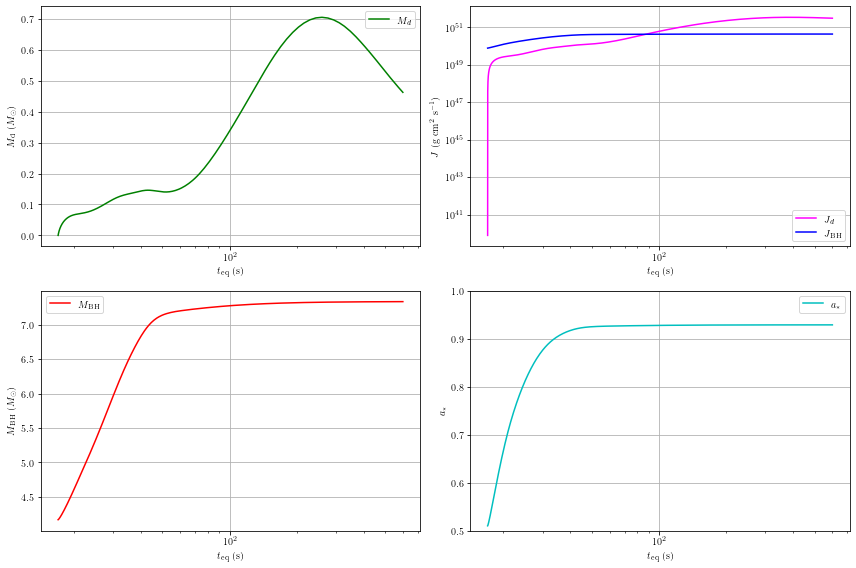

In [88]:
#plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.semilogx(times, M_d/M_sun, label=r'$M_d$ ', color="g")
plt.xlabel(r'$t_{\rm eq}$ $\rm{(s)}$')
plt.ylabel(r'${M}_{\rm d}$ ($M_\odot$)')
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 2)
plt.loglog(times, J_d, label=r'$J_d$ ', color = "magenta")
plt.loglog(times, J_BH, label=r'$J_{\rm BH}$ ', color = "blue")
plt.xlabel(r'$t_{\rm eq}$ $\rm{(s)}$')
plt.ylabel(r'$J\ (\rm{g\ cm}^2\ \rm{s}^{-1})$')
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 3)
plt.semilogx(times, M_BH/M_sun, label=r'$M_{\rm BH}$ ', color="r")
plt.xlabel(r'$t_{\rm eq}$ $\rm{(s)}$')
plt.ylabel(r'${M}_{\rm BH}$ ($M_\odot$)')
plt.grid(True)
#plt.xlim(1,1000)
#plt.ylim(5,10)
plt.legend()

plt.subplot(2, 2, 4)
plt.semilogx(times, a_star, label=r'$a_*$ ',color="c")
plt.xlabel(r'$t_{\rm eq}$ $\rm{(s)}$')
plt.ylabel(r'$a_*$')
plt.ylim(0.5,1)
#plt.xlim(1,600)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [89]:
# Testings
t_initial = t0
y0 = [M_d0, J_d0, M_BH0, J_BH0]
initial_dot_M_d = Mfb_dot_interp(t_initial) - dot_m_acc(M_d0, J_d0, M_BH0) * M_sun
initial_dot_J_d = Jfb_dot_interp(t_initial) - dot_J_acc(M_BH0, J_BH0, M_d0, J_d0)

print(f"(M_d0, J_d0, M_BH0, J_BH0) = {(M_d0/M_sun):.2e}, {J_d0:.2e}, {(M_BH0/M_sun):.2e}, {J_BH0:.2e}")
print(f"Initial time: {t_initial:.2f} s")
print(f"Initial a_star_M_BH: {a_star_BH(J_BH0, M_BH0):.2f}\n")
print(f"Initial R_S: {R_S(M_BH0):.2e} cm")
print(f"Initial Risco: {R_isco_BH(M_BH0, J_BH0):.2e} cm")
print(f"Initial r_d: {r_d(J_d0, M_d0, M_BH0):.2e} cm")
print(f"Initial r_t: {r_t(M_d0, J_d0, M_BH0):.2e} cm \n")
print(f"Initial t_acc: {t_acc(M_BH0, J_d0, M_d0):.2e} s")
print(f"Initial j_isco: {j_isco(M_BH0, J_BH0):.2e} \n")
print(f"Initial dot_M_fb: {Mfb_dot_interp(t_initial):.2e} g/s")
print(f"Initial dot_m_acc: {dot_m_acc(M_d0, J_d0, M_BH0):.2e} g/s")
print(f"Initial dot_M_d: {initial_dot_M_d:.2e} g/s \n")
print(f"Initial dot_J_fb: {Jfb_dot_interp(t_initial):.2e}  ")
print(f"Initial dot_J_acc: {dot_J_acc(M_BH0, J_BH0, M_d0, J_d0):.2e}  ")
print(f"Initial dot_J_d: {initial_dot_J_d:.2e}  \n")
print(f"Initial dot_M_BH: {dot_m_BH(M_d0, J_d0, M_BH0, J_BH0):.2e} g/s")
print(f"Initial dot_J_BH: {dot_J_BH(M_d0, J_d0, M_BH0, J_BH0):.2e} ")


(M_d0, J_d0, M_BH0, J_BH0) = 4.17e-10, 7.81e+39, 4.17e+00, 7.81e+49
Initial time: 17.00 s
Initial a_star_M_BH: 0.51

Initial R_S: 1.23e+06 cm
Initial Risco: 2.58e+06 cm
Initial r_d: 1.60e+05 cm
Initial r_t: 5.54e+01 cm 

Initial t_acc: 5.45e-05 s
Initial j_isco: 5.33e+16 

Initial dot_M_fb: 3.41e+32 g/s
Initial dot_m_acc: 7.65e-06 g/s
Initial dot_M_d: 3.41e+32 g/s 

Initial dot_J_fb: 1.52e+49  
Initial dot_J_acc: 3.33e+45  
Initial dot_J_d: 1.52e+49  

Initial dot_M_BH: 3.07e-05 g/s
Initial dot_J_BH: 3.26e+45 


In [90]:
Dot_M_BH = np.gradient(M_BH, times) 

def eta_j(a_star):
    return 0.07 * (a_star / (1 + np.sqrt(1 - a_star**2)))**5

def L_jet(dot_M_BH, a_star):
    eta = eta_j(a_star)
    return eta * dot_M_BH * c**2


# ODE System
def ODE_system(t, y):
    M_d, J_d, M_BH, J_BH = y
    
    # Definitions on rates in cgs
    Dot_Mfb = Mfb_dot_interp(t)
    Dot_Jfb = Jfb_dot_interp(t)
    Dot_Macc = dot_m_acc(J_d=J_d, M_d=M_d, M_BH=M_BH) * M_sun
    Dot_Jacc = dot_J_acc(M_BH=M_BH, J_BH=J_BH, M_d=M_d, J_d=J_d)
    Dot_MBH = dot_m_BH(M_BH=M_BH, J_BH=J_BH, J_d=J_d, M_d=M_d) * M_sun
    Dot_JBH = dot_J_BH(M_BH=M_BH, J_BH=J_BH, J_d=J_d, M_d=M_d)

    #Actual ODE
    Dot_M_d = Dot_Mfb - Dot_Macc
    Dot_J_d = Dot_Jfb - Dot_Jacc
    Dot_M_BH = Dot_MBH
    Dot_J_BH = Dot_JBH

    return [Dot_M_d, Dot_J_d, Dot_M_BH, Dot_J_BH]

a_star = (c * J_BH) / (G * M_BH**2)
eta_vals = eta_j(a_star)
L_jet_vals = L_jet(Dot_M_BH, a_star)

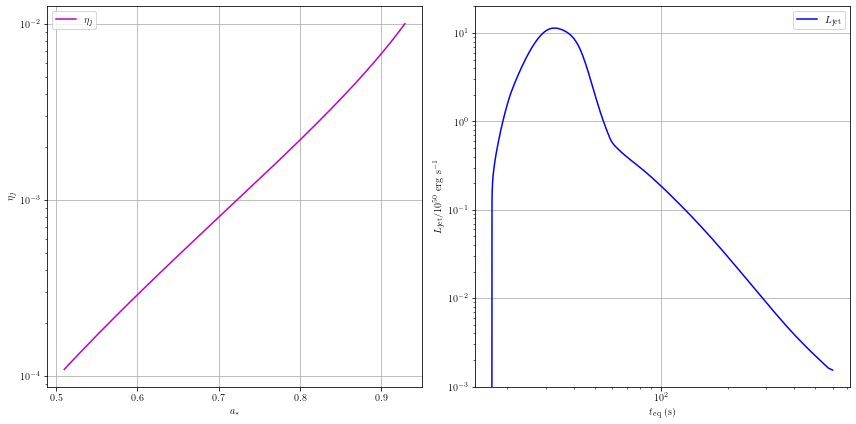

In [91]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.semilogy(a_star, eta_vals, label=r'$\eta_j$',color="m")
plt.xlabel(r'$a_*$')
plt.ylabel(r'$\eta_j$')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.loglog(times, L_jet_vals/1e50, label=r' $L_{\rm jet}$',color="b")
plt.ylabel(r"$L_{\rm jet}/10^{50}$ erg s$^{-1}$")
plt.xlabel(r'$t_{\rm eq}$ $\rm{(s)}$')
plt.ylim(1e-3,2e1)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()



In [92]:
results = {}
s_values = [0, 0.25, 0.5, 0.75, 0.99]


alpha = 0.1  # Viscosity parameter
s = 0.5  # Model parameter


for s in s_values:

    # Constants and initial conditions setup
    G = 6.67430e-8  # Gravitational constant, cm^3 g^-1 s^-2
    c = 2.99792458e10  # Speed of light, cm/s
    M_sun = 1.989e33  # Solar mass, g

    alpha = 0.1  # Viscosity parameter
    #s = 0.5  # Model parameter

    
    # Initial conditions
    t0 = 17
    a_star0 = 0.51
    M_BH0 = 4.17 * M_sun  # Initial black hole mass
    #a_star0 = 0.45
    #M_BH0 = 5.7 * M_sun

    J_BH0 = (a_star0 * G * M_BH0**2) / c  # Initial black hole angular momentum calculated from a_star0
    M_d0 = 1e-10 * M_BH0   # Initial disk mass
    J_d0 = 1e-1 * J_BH0 # Initial disk angular momentum

    # Load DataFrame and interpolation functions
    df = pd.read_csv('data.csv')
    df.sort_values(by='avg_teq', inplace=True)
    Mfb_dot_interp = interp1d(df['avg_teq'], df['Mfb_dot'], bounds_error=False, fill_value="extrapolate")
    Jfb_dot_interp = interp1d(df['avg_teq'], df['Jfb_dot'], bounds_error=False, fill_value="extrapolate")


    # Functions
    def a_star_BH(J_BH, M_BH):
        return (c * J_BH) / (G * M_BH**2)

    def R_S(M_BH):
        return 2 * G * M_BH / c**2

    def R_isco_BH(M_BH, J_BH):
        a_star_val = a_star_BH(J_BH=J_BH, M_BH=M_BH)  # Use the spin parameter from a_star_BH function
        z1 = 1 + (1 - a_star_val**2)**(1/3) * ((1 + a_star_val)**(1/3) + (1 - a_star_val)**(1/3))
        z2 = np.sqrt(3 * a_star_val**2 + z1**2)
        return (G * M_BH / c**2) * (3 + z2 - np.sqrt((3 - z1) * (3 + z1 + 2 * z2)))

    def j_isco(M_BH, J_BH):
        a_star_val = a_star_BH(M_BH=M_BH, J_BH=J_BH)
        R_isco_val = R_isco_BH(M_BH=M_BH, J_BH=J_BH)
        R_s_val = R_S(M_BH=M_BH)
        numerator = (R_isco_val**2 - a_star_val * R_s_val * np.sqrt(R_isco_val * R_s_val / 2) + a_star_val**2 * R_s_val**2 / 4)
        denominator = R_isco_val * np.sqrt(R_isco_val**2 - 3 * R_isco_val * R_s_val / 2 + a_star_val * R_s_val * np.sqrt(R_isco_val * R_s_val / 2))

        return np.sqrt(G * M_BH * R_isco_val) * numerator / denominator

    def r_d(J_d, M_d, M_BH):
        return ((J_d / M_d)**2) / (G * M_BH)

    def t_acc(M_BH, J_d, M_d):
        r_d_val =  r_d(J_d=J_d, M_d=M_d, M_BH=M_BH)
        Omega_k_BH = np.sqrt(G * M_BH / r_d_val**3)
        return 2 / (alpha * Omega_k_BH)

    def dot_m_acc(M_d, J_d, M_BH): #Adimensional dot_m_acc (dotmacc/(M_sun/s))
        r_d_val = r_d(J_d=J_d, M_d=M_d, M_BH=M_BH)
        t_acc_val = t_acc(J_d=J_d, M_d=M_d, M_BH=M_BH)
        dot_M_acc = M_d / t_acc_val  
        dot_m_acc_val = dot_M_acc / M_sun 
        return dot_m_acc_val


    def r_t(M_d, J_d, M_BH):
        R_s_val = R_S(M_BH=M_BH)
        r_d_val = r_d(J_d=J_d, M_d=M_d, M_BH=M_BH)
        dot_m_acc_val = dot_m_acc(J_d=J_d, M_d=M_d, M_BH=M_BH)
        return R_s_val * (10 ** 2.5 * dot_m_acc_val * (r_d_val / R_s_val) ** -s) ** (1 / (1 - s))

    # Conditional function for dot_M_BH based on accretion regimes
    def dot_m_BH(M_d, J_d, M_BH, J_BH):
        R_s_val = R_S(M_BH=M_BH)
        r_d_val = r_d(J_d=J_d, M_d=M_d, M_BH=M_BH)
        R_isco_val = R_isco_BH(M_BH=M_BH, J_BH=J_BH)
        dot_m_acc_val = dot_m_acc(J_d=J_d, M_d=M_d, M_BH=M_BH)

        log_dot_macc = np.log10(dot_m_acc_val)
        log_rd_Rs = np.log10(r_d_val / R_s_val)
        log_Risco_Rs = np.log10(R_isco_val / R_s_val)
        log_rd_Risco = np.log10(r_d_val / R_isco_val)

        #return dot_m_acc_val

        # NDAF
        if log_rd_Rs - 2.5 <= log_dot_macc:
            #print("NDAF regime")
            return dot_m_acc_val
        # NADAF
        elif log_Risco_Rs + s * log_rd_Risco - 2.5 <= log_dot_macc < log_rd_Rs - 2.5:
            #print("NADAF regime")
            return np.power(10, (1 / (1 - s)) * (log_dot_macc - s * log_rd_Rs + 2.5 * s))
        # ADAF
        elif log_dot_macc < log_Risco_Rs + s * log_rd_Risco - 2.5:
            #print("ADAF regime")
            return np.power(10, log_dot_macc - s * log_rd_Risco)




    # Function for dot_J_acc
    def dot_J_acc(M_BH, J_BH, M_d, J_d):
        R_s_val = R_S(M_BH=M_BH)
        R_isco_val = R_isco_BH(M_BH=M_BH, J_BH=J_BH)
        j_isco_val = j_isco(M_BH=M_BH, J_BH=J_BH)
        r_d_val = r_d(J_d=J_d, M_d=M_d, M_BH=M_BH)
        jr_d_val = np.sqrt(G * M_BH * r_d_val)
        dot_M_acc_val = dot_m_acc(J_d=J_d, M_d=M_d, M_BH=M_BH) * M_sun
        dot_M_BH_val = dot_m_BH(M_BH=M_BH, J_BH=J_BH, J_d=J_d, M_d=M_d) * M_sun
        r_t_val = r_t(M_BH=M_BH, J_d=J_d, M_d=M_d)

        return j_isco_val * dot_M_BH_val + (2 * s / (2 * s + 1)) * jr_d_val * dot_M_acc_val * (1 - (r_t_val / r_d_val)**((2 * s + 1) / 2))


    def dot_J_BH(M_d, J_d, M_BH, J_BH):
        j_isco_val = j_isco(M_BH=M_BH, J_BH=J_BH)
        dot_M_BH_val = dot_m_BH(M_BH=M_BH, J_BH=J_BH, J_d=J_d, M_d=M_d) * M_sun
        return dot_M_BH_val * j_isco_val

    def eta_j(a_star):
        return 0.07 * (a_star / (1 + np.sqrt(1 - a_star**2)))**5

    def L_jet(dot_M_BH, a_star):
        eta = eta_j(a_star)
        return eta * dot_M_BH * c**2



    # ODE System
    def ODE_system(t, y):
        M_d, J_d, M_BH, J_BH = y

        # Definitions on rates in cgs
        Dot_Mfb = Mfb_dot_interp(t)
        Dot_Jfb = Jfb_dot_interp(t)
        Dot_Macc = dot_m_acc(J_d=J_d, M_d=M_d, M_BH=M_BH) * M_sun
        Dot_Jacc = dot_J_acc(M_BH=M_BH, J_BH=J_BH, M_d=M_d, J_d=J_d)
        Dot_MBH = dot_m_BH(M_BH=M_BH, J_BH=J_BH, J_d=J_d, M_d=M_d) * M_sun
        Dot_JBH = dot_J_BH(M_BH=M_BH, J_BH=J_BH, J_d=J_d, M_d=M_d)

        #Actual ODE
        Dot_M_d = Dot_Mfb - Dot_Macc
        Dot_J_d = Dot_Jfb - Dot_Jacc
        Dot_M_BH = Dot_MBH
        Dot_J_BH = Dot_JBH

        return [Dot_M_d, Dot_J_d, Dot_M_BH, Dot_J_BH]


    t_span = (t0, 600)
    t_eval = np.linspace(t0,600,1000)
    y0 = [M_d0, J_d0, M_BH0, J_BH0] 

    sol = solve_ivp(ODE_system, t_span, y0, dense_output=True, t_eval=t_eval, rtol=1e-6, atol=1e-9)


    times = sol.t
    M_d = sol.y[0]
    J_d = sol.y[1]
    M_BH = sol.y[2]
    J_BH = sol.y[3]

    Dot_M_BH = np.gradient(M_BH, times) 
    a_star = (c * J_BH) / (G * M_BH**2)
    L_jet_vals = L_jet(Dot_M_BH, a_star)

    results[str(s)] = {
        'times': times,
        'L_jet': L_jet_vals,
        'M_d': M_d,
        'J_d': J_d,
        'J_BH': J_BH,
        'M_BH': M_BH,
        'a_star': a_star
    }  

/tmp/ipykernel_1553136/2972198908.py:65: RuntimeWarning: overflow encountered in double_scalars
  Omega_k_BH = np.sqrt(G * M_BH / r_d_val**3)
/tmp/ipykernel_1553136/2972198908.py:66: RuntimeWarning: divide by zero encountered in double_scalars
  return 2 / (alpha * Omega_k_BH)
/tmp/ipykernel_1553136/2972198908.py:89: RuntimeWarning: divide by zero encountered in log10
  log_dot_macc = np.log10(dot_m_acc_val)


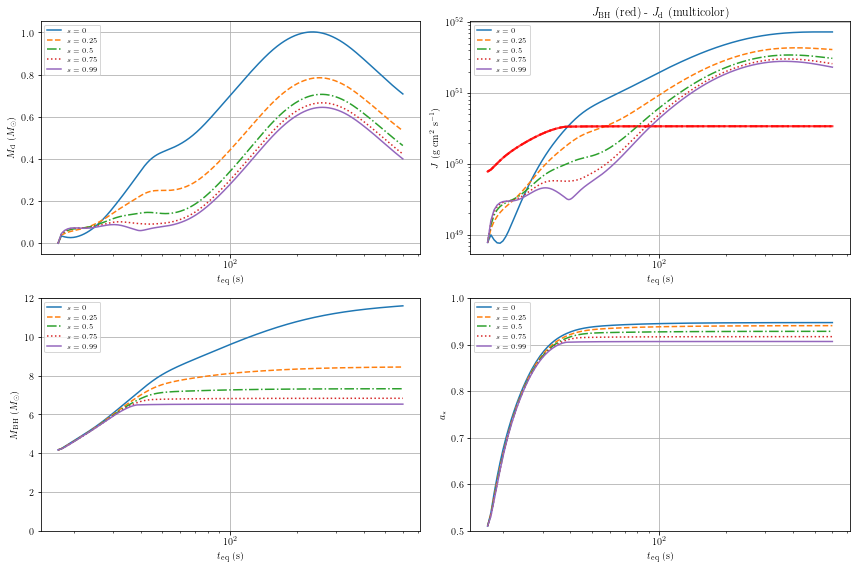

In [93]:
plt.figure(figsize=(12, 8))

# Definir estilos de línea para diferenciar cada valor de 's'
line_styles = ['-', '--', '-.', ':']

# Iterar sobre cada simulación guardada en el diccionario 'results'
for i, (s, data) in enumerate(results.items()):
    style = line_styles[i % len(line_styles)]
    times = data['times']
    M_d = data['M_d']
    J_d = data['J_d']
    M_BH = data['M_BH']
    a_star = data['a_star']

    # Panel 1: Masa del disco
    plt.subplot(2, 2, 1)
    plt.semilogx(times, M_d/M_sun, linestyle=style, label=f'$s={s}$')
    plt.xlabel(r'$t_{\rm eq}$ $\rm{(s)}$')
    plt.ylabel(r'${M}_{\rm d}$ ($M_\odot$)')
    plt.grid(True)
    plt.legend(loc='best', fontsize='x-small', frameon=True, handlelength=2)

    # Panel 2: Momento angular
    plt.subplot(2, 2, 2)
    plt.loglog(times, J_d, linestyle=style, label=f'$s={s}$')
    plt.loglog(times, J_BH, linestyle=style, color="red", linewidth=2, alpha=0.5)
    plt.xlabel(r'$t_{\rm eq}$ $\rm{(s)}$')
    plt.ylabel(r'$J\ (\rm{g\ cm}^2\ \rm{s}^{-1})$')
    plt.title(r"$J_{\rm BH}$ (red) - $J_{\rm d}$ (multicolor)" )
    plt.grid(True)
    plt.legend(loc='best', fontsize='x-small', frameon=True, handlelength=2)

    # Panel 3: Masa del agujero negro
    plt.subplot(2, 2, 3)
    plt.semilogx(times, M_BH/M_sun, linestyle=style, label=f'$ s={s}$')
    plt.xlabel(r'$t_{\rm eq}$ $\rm{(s)}$')
    plt.ylabel(r'${M}_{\rm BH}$ ($M_\odot$)')
    ticks_y_Mr = [0, 2, 4, 6, 8, 10, 12]
    plt.yticks(ticks_y_Mr)
    plt.grid(True)
    plt.legend(loc='best', fontsize='x-small', frameon=True, handlelength=2)

    # Panel 4: Parámetro de spin
    plt.subplot(2, 2, 4)
    plt.semilogx(times, a_star, linestyle=style, label=f'$ s={s}$')
    plt.xlabel(r'$t_{\rm eq}$ $\rm{(s)}$')
    plt.ylabel(r'$a_*$')
    plt.ylim(0.5, 1)
    plt.grid(True)
    plt.legend(loc='best', fontsize='x-small', frameon=True, handlelength=2)

plt.tight_layout()
plt.show()


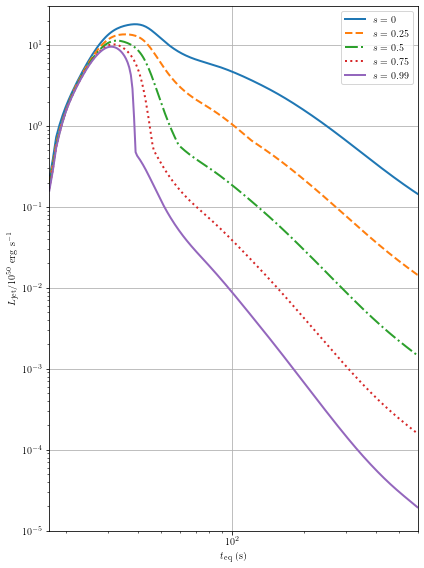

In [94]:
plt.figure(figsize=(6, 8))

line_styles = ['-', '--', '-.', ':']

for i, (s, data) in enumerate(results.items()):
    style = line_styles[i % len(line_styles)]
    times = data['times'] 
    L_jet_vals = data['L_jet']  

    plt.loglog(times, L_jet_vals/1e50, linestyle=style, label=f'$s={s}$', markersize=8, linewidth=2)

plt.ylabel(r"$L_{\rm jet}/10^{50}$ erg s$^{-1}$")
plt.xlabel(r'$t_{\rm eq}$ $\rm{(s)}$')
plt.ylim(1e-5, 3e1)
plt.xlim(t0, 600)
plt.grid(True)
plt.legend(loc='best',frameon=True, handlelength=2)


plt.tight_layout()
plt.show()


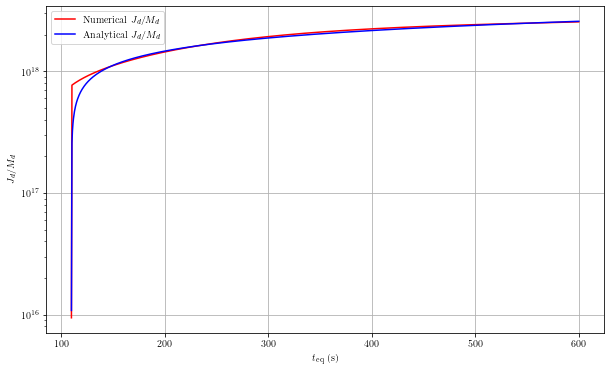

In [95]:
output_path = '../plots'

alpha = 0.1  # Viscosity parameter
s = 0.5 # Model parameter

t0 = 110  # Initial time
a_star0 = 0.51  # Initial spin parameter
M_BH0 = 4.17 * M_sun  # Initial black hole mass
J_BH0 = (a_star0 * G * M_BH0**2) / c  # Initial black hole angular momentum
#M_d0 = 1.5812877234756064e+33  # Initial disk mass
#J_d0 = 2.2802915729290682e+51    # Initial disk angular momentum
M_d0 = 1e-10 * M_BH0  
J_d0 = 1e-10 * J_BH0
y0 = [M_d0, J_d0, M_BH0, J_BH0]

t_acc_prime = 2 / (alpha * G**2 * M_BH0**2) * (J_d0 / M_d0)**3
t_eval = np.linspace(t0, 600, 1000)
t_span = (t0, 600)
y0 = [M_d0, J_d0, M_BH0, J_BH0] 

# ODE System
def ODE_system2(t, y):
    M_d, J_d, M_BH, J_BH = y
    R_d_val = r_d(M_BH=M_BH, J_d=J_d, M_d=M_d)
    J_isco_val = j_isco(M_BH=M_BH, J_BH=J_BH)

    # Definitions on rates in cgs
    Dot_Mfb = Mfb_dot_interp(t)
    Dot_Jfb = Jfb_dot_interp(t)
    Dot_Macc = dot_m_acc(J_d=J_d, M_d=M_d, M_BH=M_BH) * M_sun
    Dot_Jacc = dot_J_acc(M_BH=M_BH, J_BH=J_BH, M_d=M_d, J_d=J_d)
    Dot_MBH = dot_m_BH(M_BH=M_BH, J_BH=J_BH, J_d=J_d, M_d=M_d) * M_sun
    Dot_JBH = dot_J_BH(M_BH=M_BH, J_BH=J_BH, J_d=J_d, M_d=M_d)

    #Actual ODE
    Dot_M_d = Dot_Mfb - Dot_Macc
    Dot_J_d = Dot_Jfb - Dot_Jacc
    Dot_M_BH = Dot_MBH
    Dot_J_BH = Dot_JBH

    return [Dot_M_d, Dot_J_d, Dot_M_BH, Dot_J_BH]

sol = solve_ivp(ODE_system2, t_span, y0, dense_output=True, t_eval=t_eval, rtol=1e-6, atol=1e-9)


# Analytical solutions
def Jd_Md(t, J_d0, M_d0, t_acc_prime, s):
    factor = 1 + 3 / (2 * s + 1) * (t - t0) / t_acc_prime
    return 1.15*(J_d0 / M_d0) * factor**(1/3)

def analytical_r_d(t, J_d0, M_d0, M_BH0, t_acc_prime, s):
    factor = 1 + 3 / (2 * s + 1) * (t - t0) / t_acc_prime
    return (J_d0 / M_d0)**2 / (G * M_BH0) * factor**(2/3)

def analytical_Omega_k(t, J_d0, M_d0, M_BH0, t_acc_prime, s):
    r_d = analytical_r_d(t, J_d0, M_d0, M_BH0, t_acc_prime, s)
    return np.sqrt(G * M_BH0 / r_d**3)

J_d_M_d_ratio_analytical = Jd_Md(t_eval, J_d0, M_d0, t_acc_prime, s)
J_d_M_d_ratio_numerical = sol.y[1]/sol.y[0]


plt.figure(figsize=(10, 6))
plt.semilogy(t_eval, J_d_M_d_ratio_numerical, 'r-', label='Numerical $J_d/M_d$')
plt.semilogy(t_eval, J_d_M_d_ratio_analytical, 'b-', label='Analytical $J_d/M_d$')
plt.xlabel(r'$t_{\rm eq}$ $\rm{(s)}$')
plt.ylabel('$J_d/M_d$ ')
plt.legend()
plt.grid(True)
plt.show()


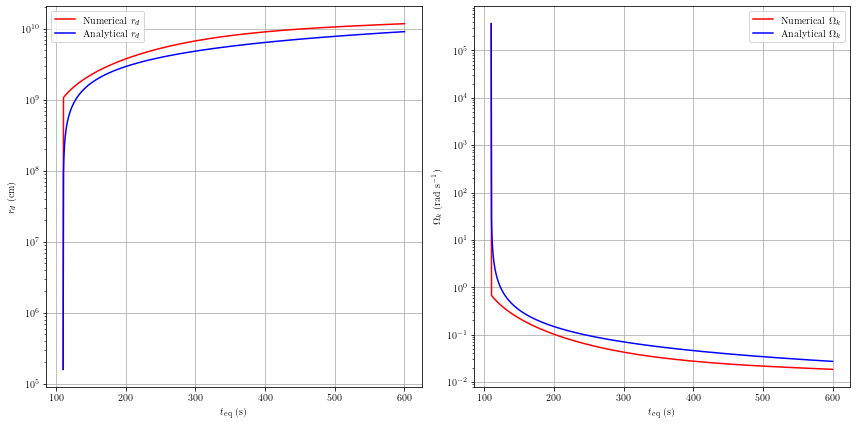

In [96]:
# Analytical values
r_d_analytical = analytical_r_d(t_eval, J_d0, M_d0, M_BH0, t_acc_prime, s)
Omega_k_analytical = analytical_Omega_k(t_eval, J_d0, M_d0, M_BH0, t_acc_prime, s)

# Numerical results
r_d_numerical = (sol.y[1] / sol.y[0])**2 / (G * M_BH0)
Omega_k_numerical = np.sqrt(G * M_BH0 / r_d_numerical**3)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.semilogy(t_eval, r_d_numerical, 'r-', label='Numerical $r_d$')
plt.semilogy(t_eval, r_d_analytical, 'b-', label='Analytical $r_d$')
plt.xlabel(r'$t_{\rm eq}$ $\rm{(s)}$')
plt.ylabel('$r_d$ (cm)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.semilogy(t_eval, Omega_k_numerical, 'r-', label='Numerical $\Omega_k$')
plt.semilogy(t_eval, Omega_k_analytical, 'b-', label='Analytical $\Omega_k$')
plt.xlabel(r'$t_{\rm eq}$ $\rm{(s)}$')
plt.ylabel('$\Omega_k$ (rad s$^{-1}$)')
plt.legend()
plt.grid(True)

plt.tight_layout()
output_plot_path = f'plots/Comparisons_Rd_Omega_k.pdf'
os.makedirs('plots', exist_ok=True)
plt.savefig(output_plot_path, format="pdf")
plt.show()



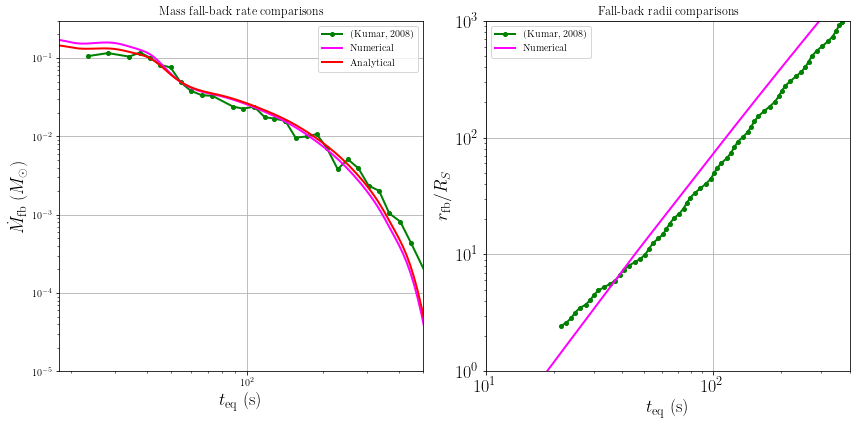

In [105]:


# 1. Cargar e interpolar los datos de densidad
data_rhoR = pd.read_csv('./Data/log_rho_vs_r.csv', header=None, sep=';', decimal=',')
radius_values_rho = data_rhoR[0].values
log_rho_values_r = data_rhoR[1].values
density_function_log_r = interp1d(radius_values_rho, log_rho_values_r, kind='cubic', fill_value="extrapolate", bounds_error=False)


def rho_interpolated(r):
    """Returns rho(r) in g/cm^3 by exponentiating the interpolated log(rho)."""
    log_density = density_function_log_r(r)  # Usamos la variable renombrada
    return 10**log_density

def dln_Omega_k_dr(r):
    return -(3 / (2 * r))

def t_eq(r):
    return np.interp(r, df['r'], df['avg_teq'])

# 3. Definir otras funciones que usan rho_interpolated, como M_dot_fb
def M_dot_fb(r):
    term1 = 4 * np.pi * r**2 * rho_interpolated(r)
    term2 = t_eq(r) * np.abs(dln_Omega_k_dr(r))
    return term1 / term2

# 4. Aplicar la función a la columna del DataFrame
df['Mfb_analytical'] = df['r'].apply(M_dot_fb)

time1 = df_mfb[0].values
mfb1 = df_mfb[1].values

time2 = df_rfb[0].values
rfb2 = df_rfb[1].values

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].loglog(time1, mfb1, 'o-', markersize=4, linewidth=2, label="(Kumar, 2008)", color="green")
ax[0].loglog(df['avg_teq'], df['Mfb_dot']/M_sun, linewidth=2, color="magenta", label="Numerical")
ax[0].loglog(df['avg_teq'], df['Mfb_analytical']/M_sun, linewidth=2, color="red", label="Analytical")
ax[0].set_xlabel(r'$t_{\rm eq}$ (s)', fontsize=18)
ax[0].set_xlim(18, 500)
ax[0].set_ylim(1e-5, 3e-1)
ax[0].set_ylabel(r'$\dot{M}_{\rm fb}$ ($M_\odot$)', fontsize=18)
ax[0].set_title('Mass fall-back rate comparisons')
ax[0].grid(True)
ax[0].legend()

ax[1].loglog(time2, rfb2, 'o-', markersize=4, linewidth=2, label="(Kumar, 2008)", color="green")
ax[1].loglog(df['avg_teq'], df['avg_req']/(1.4*R_Sch), linewidth=2, color="magenta",label="Numerical")
ax[1].set_xlabel(r'$t_{\rm eq}$ (s)', fontsize=18)
ax[1].set_xlim(10, 400)
ax[1].set_ylim(1, 1e3)
ax[1].set_ylabel(r'${r}_{\rm fb}/R_S$', fontsize=18)
ax[1].set_title('Fall-back radii comparisons')
ax[1].grid(True)
ax[1].legend()

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
output_plot_path = f'plots/Mdot_R_Kumar.pdf'
os.makedirs('plots', exist_ok=True)
plt.savefig(output_plot_path, format="pdf")
plt.show()



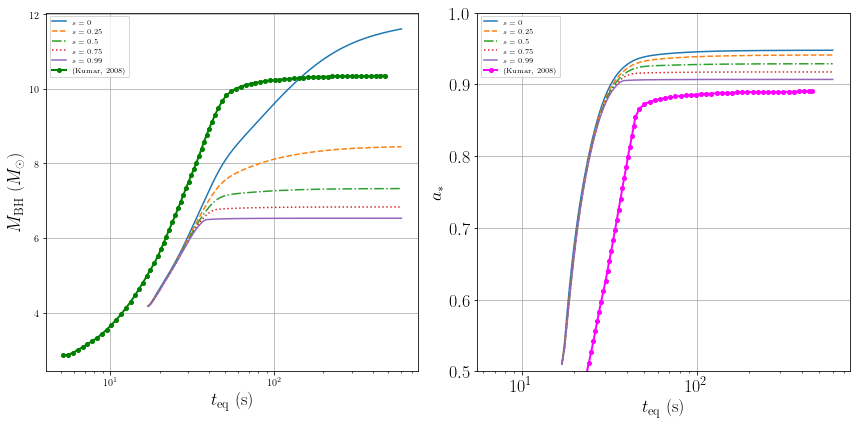

In [107]:

df_mbh = pd.read_csv('./Data/mbh.csv', header=None)
df_spin = pd.read_csv('./Data/spin.csv', header=None)

df = pd.read_csv('data.csv')

time_mbh = df_mbh[0].values
mbh_interpolated = df_mbh[1].values

time_spin = df_spin[0].values
spin_interpolated = df_spin[1].values

line_styles = ['-', '--', '-.', ':']

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
for i, (s, data) in enumerate(results.items()):
    style = line_styles[i % len(line_styles)]
    plt.semilogx(data['times'], data['M_BH']/M_sun, linestyle=style, label=f'$s={s}$')
plt.semilogx(time_mbh, mbh_interpolated, 'o-', markersize=4, linewidth=2, color="green", label="(Kumar, 2008) ")
plt.xlabel(r'$t_{\rm eq}$ $\rm{(s)}$', fontsize=18)
plt.ylabel(r'${M}_{\rm BH}$ ($M_\odot$)', fontsize=18)
plt.grid(True)
plt.legend(loc='best', fontsize='x-small', frameon=True, handlelength=2)

plt.subplot(1, 2, 2)
for i, (s, data) in enumerate(results.items()):
    style = line_styles[i % len(line_styles)]
    plt.semilogx(data['times'], data['a_star'], linestyle=style, label=f'$s={s}$')
plt.semilogx(time_spin, spin_interpolated, 'o-', markersize=4, linewidth=2, color="magenta", label="(Kumar, 2008)")
plt.xlabel(r'$t_{\rm eq}$ $\rm{(s)}$', fontsize=18)
plt.ylabel(r'$a_*$', fontsize=18)
plt.ylim(0.5, 1)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.legend(loc='best', fontsize='x-small', frameon=True, handlelength=2)

plt.tight_layout()
output_plot_path = f'plots/MBH_spin_Kumar.pdf'
os.makedirs('plots', exist_ok=True)
plt.savefig(output_plot_path, format="pdf")
plt.show()


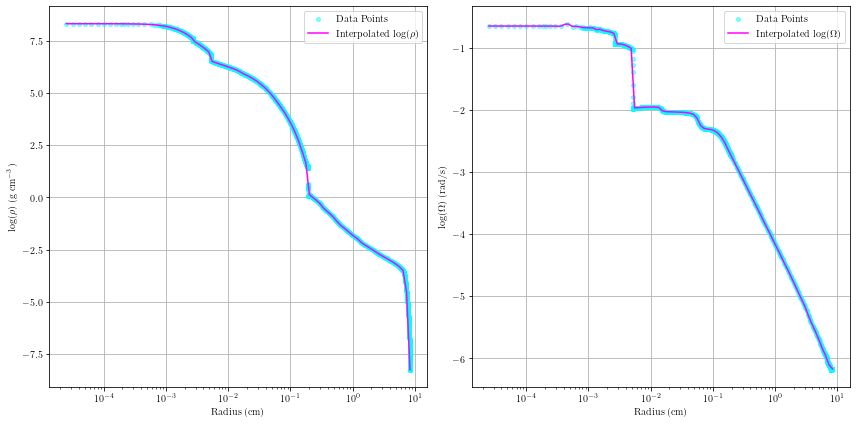

In [99]:
# Load data from a CSV file, assuming whitespace delimiter
df = pd.read_csv('./Data/60mass.dat', delim_whitespace=True, header=None)

# Define the names of the columns
df.columns = [
    'Radius', 'Mass', 'Log_P', 'Log_Rho', 'Log_T',
    'L_r', 'Pgas_P', 'Log_jrot', 'L_m', 'v_csound',
    'omega', 'v_rot', 'csound', 'Extra_Column'
]

# Convert data types to float where necessary
df['Radius'] = pd.to_numeric(df['Radius'], errors='coerce')
df['omega'] = pd.to_numeric(df['omega'], errors='coerce')
df['Log_Rho'] = pd.to_numeric(df['Log_Rho'], errors='coerce')

# Remove rows where any critical data might have been converted to NaN
df.dropna(subset=['Radius', 'omega', 'Log_Rho'], inplace=True)

# Group by 'Radius' and compute the mean of 'omega' and 'Log_Rho' for each group
grouped_omega = df.groupby('Radius')['omega'].mean().reset_index()
grouped_rho = df.groupby('Radius')['Log_Rho'].mean().reset_index()

# Create interpolated functions for omega and rho
Omega_function = interp1d(grouped_omega['Radius'], np.log10(grouped_omega['omega']), kind='cubic', fill_value="extrapolate")
Rho_function = interp1d(grouped_rho['Radius'], grouped_rho['Log_Rho'], kind='cubic', fill_value="extrapolate")

# Define the interpolated Omega and Rho functions
def Omega_interpolated(r):
    return 10 ** Omega_function(r)

def Rho_interpolated(r):
    return Rho_function(r)

# Prepare radius values for plotting
r_values = np.logspace(np.log10(df['Radius'].min()), np.log10(df['Radius'].max()), 100)

# Plot log(Rho) and log(Omega) as functions of Radius in subplots
plt.figure(figsize=(12, 6))

# Plot for Log_Rho
plt.subplot(1, 2, 1)
plt.semilogx(df['Radius'], df['Log_Rho'], 'o', markersize=4, color='cyan', alpha=0.5, label="Data Points")
plt.semilogx(r_values, [Rho_interpolated(r) for r in r_values], color="magenta", label=r"Interpolated $\log(\rho)$")
plt.xlabel(r'Radius (cm)')
plt.ylabel(r'$\log(\rho)$ (g cm$^{-3}$)')
plt.legend()
plt.grid(True)

# Plot for Omega
plt.subplot(1, 2, 2)
plt.semilogx(df['Radius'], np.log10(df['omega']), 'o', markersize=4, color='cyan', alpha=0.5, label="Data Points")
plt.semilogx(r_values, [np.log10(Omega_interpolated(r)) for r in r_values], color="magenta", label=r"Interpolated $\log(\Omega)$")
plt.xlabel(r'Radius (cm)')
plt.ylabel(r'$\log(\Omega)$ (rad/s)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()




In [100]:
!pwd

/fs/phaethon/other0/gibran/accretion
